# PM2.5 Statistical Prediction Models_Modeling_7_ARIMA_monthly

## Quick Summary

### Key problems:
* How to choose the hyperparameters for the ARIMA and SARIMA models from ACF and PACF plots?<br>
* Why in all cases, the performance on the training set is good but the performance on the test set is very bad? Am I doing anything wrong? <br>
* SARIMA model takes a long time to train for the hourly dataset (at the end of notebook 5) <br>
* Taking the difference to remove trends and un-differencing after the model fitting and predictions alway mess up the data (see notebook 7 and 8 where the target variable is first differenced before applying the ARIMA model) <br>

### Introduction to the notebooks: 
Four notebooks are developed to test out the ARIMA and SARIMA models for various sampling frequencies:
modeling_5_ARIMA_hourly, modeling_6_ARIMA_daily, modeling_7_ARIMA_monthly and modeling_8_ARIMA_diff.<br> 
* (notebook_5) Hourly data: the hourly PM2.5 for Beijing is extracted and both ARIMA model and SARIMA model are attempted. SARIMA model takes a really long time to compute (>1day) so the result is not available.<br> 
* (notebook_6) Daily data: the hourly data is resampled by day and both ARIMA model and SARIMA model are used. <br>
* (notebook_7) Monthly data: the hourly data is resampled by month. Due to the non-stationarity, the monthly data is first transformed towards stationarity by taking the difference, then feed to the ARIMA model. Due to the limited data size in the monthly data, SARIMA is not used. <br>
* (notebook_8): in this notebook, the hourly data is first differenced to remove the underlying trend before feeding to the ARIMA model. The predicted results is then un-differenced to recover to the original scale. <br>

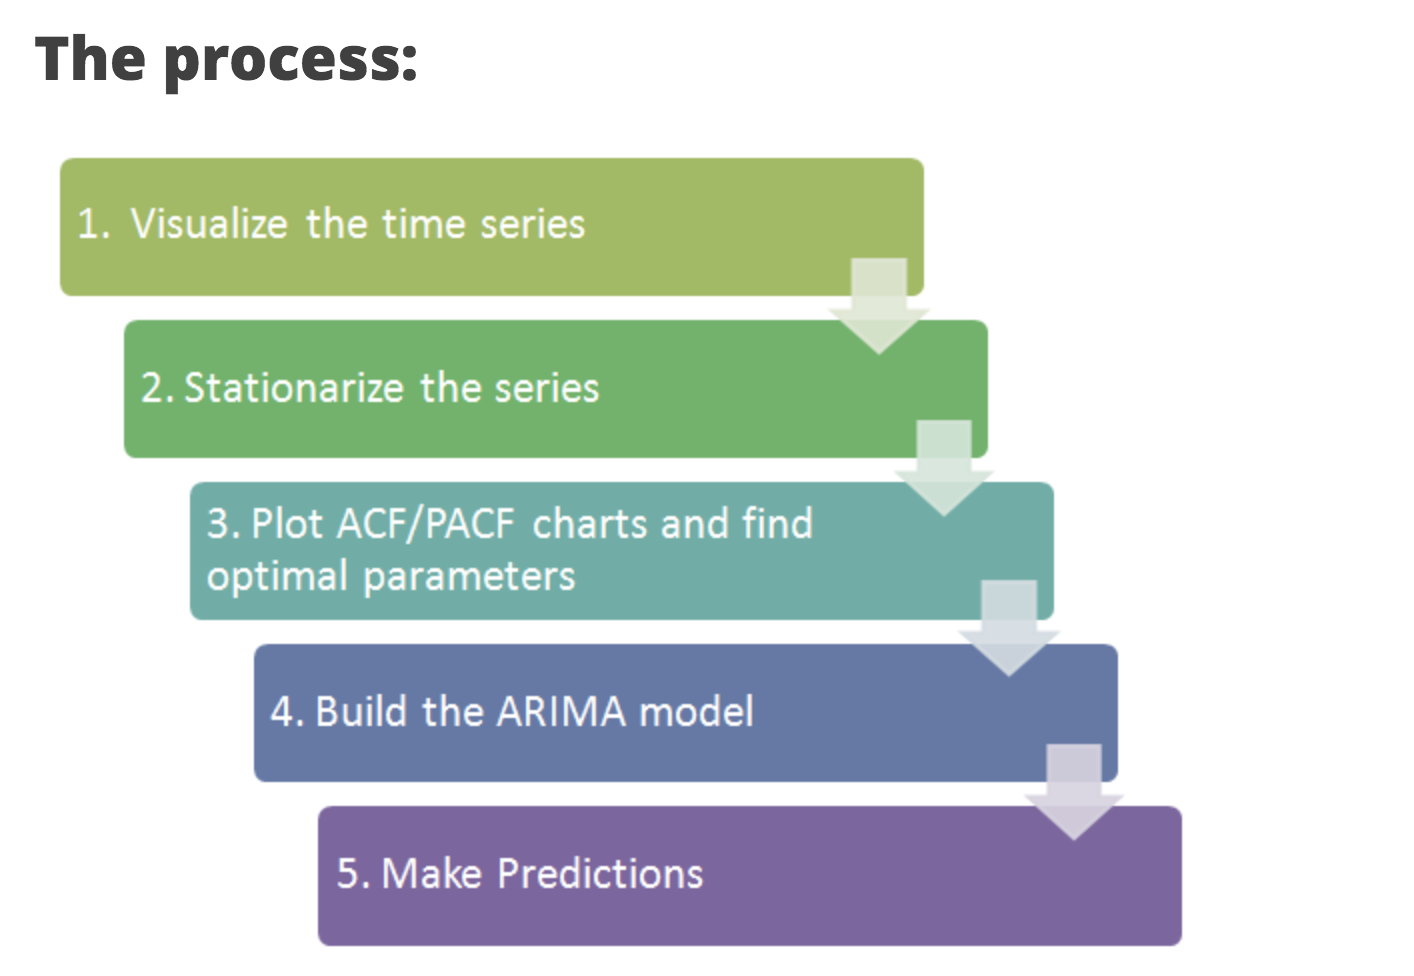

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  


In [3]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# set 'date_time' as the index and extract 'pm_average' data only
bj_hourly = bj.set_index('date_time')['pm_average']

# resample by day and aggregate using daily average
bj_monthly = bj_hourly.resample('M').mean()

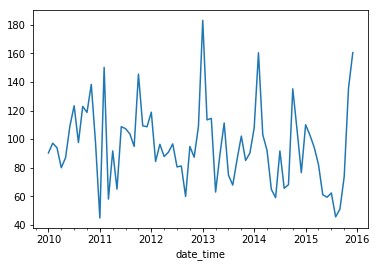

In [4]:
# plot the time series to inspect the features
bj_monthly.plot();

As shown, there is a significant seasonality component in the time series data.
Need to perform the stationary test to see if there's a need for tranforming the data.

### Test for stationarity
In order to use an ARIMA model, the Dickey-Fuller Test is conducted to determine if the time series is stationary (constant mean, variance and autocorrelation across the time series dataset).
 
<li>$H_o$: Non-stationary series
<li>$H_a$: Stationary series

In [5]:
# http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html

useful_values_raw = adfuller(bj_monthly, autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-1.106631
1,p-value,0.712420
2,#Lags Used,12.000000
3,Number of Observations Used,59.000000
4,Critical value for 1%,-3.546395
5,Critical value for 5%,-2.911939
6,Critical value for 10%,-2.593652


p-value is 0.712, we cannot reject the null hypothesis of non-stationarity. Therefore, data transformation toward stationary data is needed before ARIMA and SARIMA model can be applied.

### transform the data by taking the difference

,Label,Value
0,Test Statistic,-5.566936
1,p-value,0.000001
2,#Lags Used,12.000000
3,Number of Observations Used,58.000000
4,Critical value for 1%,-3.548494
5,Critical value for 5%,-2.912837
6,Critical value for 10%,-2.594129


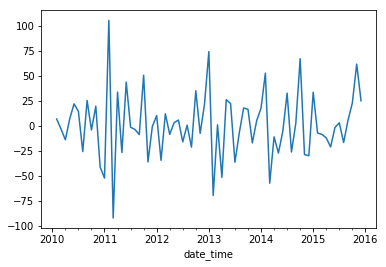

In [6]:
# taking the difference
bj_monthly_diff = bj_monthly - bj_monthly.shift(1)
bj_monthly_diff.dropna(inplace=True)

# plot for inspection
bj_monthly_diff.plot();

# Dickey-Fuller Test
useful_values_raw = adfuller(bj_monthly_diff, autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

### acf and pacf plots for identifying the model parameters

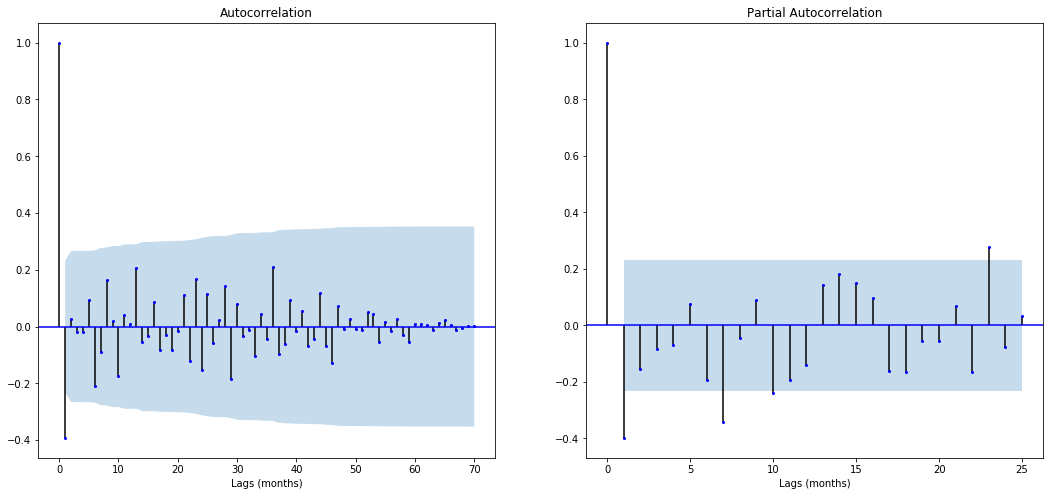

In [7]:
# look at the autocorrelation and partial autocorrelation plots to identify potential structure in the time series data

fig = plt.figure(figsize=(18,8));

ax1 = fig.add_subplot(121)
plot_acf(bj_monthly_diff, ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (months)');

ax2 = fig.add_subplot(122)
plot_pacf(bj_monthly_diff, ax=ax2, lags=25, color='blue', markersize=2);
ax2.set_xlabel('Lags (months)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1
2. The number of differences taken given that first difference is necessary: d=1
3. The number of Moving Average Terms based on the acf plot: q=1

## ARIMA model

In [8]:
# train test split

bj_monthly_train = bj_monthly.loc['2010':'2014']
bj_monthly_test = bj_monthly.loc['2015']
print(len(bj_monthly_train), len(bj_monthly_test))

60 12


In [9]:
# ARIMA model with p=1, d=1 and q=1

model_1 = ARIMA(bj_monthly_train, order=(1, 1, 1))  
result_1 = model_1.fit()
predict_1 = result_1.predict(start=len(bj_monthly_train), end=len(bj_monthly)-1, dynamic=True)
print(result_1.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.pm_average   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -276.993
Method:                       css-mle   S.D. of innovations             25.613
Date:                Wed, 12 Sep 2018   AIC                            561.986
Time:                        09:11:31   BIC                            570.296
Sample:                    02-28-2010   HQIC                           565.230
                         - 12-31-2014                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1816      0.214     -0.847      0.401      -0.602       0.239
ar.L1.D.pm_average     0.1151      0.131      0.882      0.381      -0.141       0.371
ma.L1.D.pm_average  

In [10]:
# reverse the differencing using Pandas Series .cumsum() method

result_1_cumsum = result_1.fittedvalues.cumsum()
result_1_total = pd.Series(bj_monthly_train[0], index=bj_monthly_train.index).add(result_1_cumsum, fill_value=0)

predict_1_cumsum = predict_1.cumsum()
predict_1_cumsum.index = bj_monthly_test.index
predict_1_total = pd.Series(bj_monthly_train[-1], index=bj_monthly_test.index).add(predict_1_cumsum)

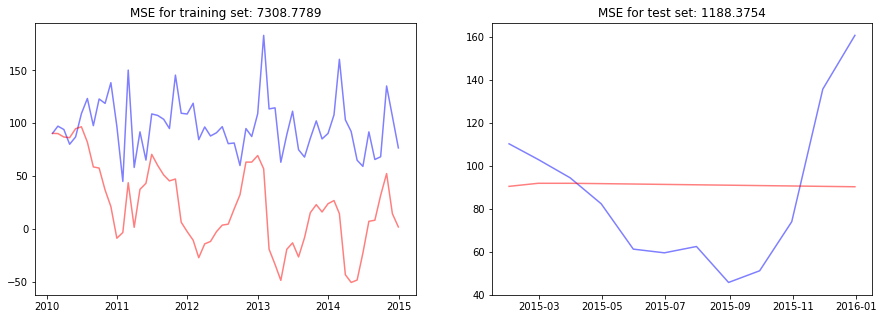

In [11]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_monthly_train, color='blue', alpha=0.5);
ax1.plot(result_1_total, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_1_total-bj_monthly_train)**2)));

ax2 = fig.add_subplot(122)
ax2.plot(bj_monthly_test, color='blue',alpha=0.5);
ax2.plot(predict_1_total, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_1_total-bj_monthly_test)**2)));

In [12]:
# table comparison of predicted values vs. actual readings

comparison = pd.DataFrame({'actual':bj_monthly_test,'predict':predict_1_total})
print(comparison)

                actual    predict
date_time                        
2015-01-31  110.150965  90.365159
2015-02-28  102.907075  91.785970
2015-03-31   94.338182  91.788861
2015-04-30   82.252155  91.628497
2015-05-31   61.167563  91.449336
2015-06-30   59.447932  91.268011
2015-07-31   62.389885  91.086438
2015-08-31   45.670009  90.904835
2015-09-30   51.095967  90.723229
2015-10-31   73.915242  90.541623
2015-11-30  135.595270  90.360016
2015-12-31  160.596899  90.178410
